# Feature selection with feature importances


In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from scripts.tracks import get_tracks
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scripts.ROC import get_ROC, plot_ROC_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', None)

#### Unpickle FE dataframe

In [4]:
event_id = 'event000001000'
data = pd.read_pickle('/home/alepfu/Desktop/dataset/pickle/' + event_id + '_FE.pkl')
data.shape

(120939, 46)

#### Pick a sample of tracks

In [5]:
N_tracks = 1000
data = get_tracks(data, N_tracks=N_tracks, drop_zero_weights=False, drop_zero_id=False, factorize_particle_id=False)
print(data.shape)

(9708, 46)


#### Set features for use in feature selection
We can only make use of information from the hit level and the engineered features.

In [6]:
data = data[['hit_id','particle_id','x','y','z','volume_id','layer_id','module_id',
             'x_scaled','y_scaled','z_scaled','r_cyl','theta','theta_atan2','r_sph','phi','phi_atan2',
             'x_r_cyl','y_r_cyl','z_r_cyl','x_r_sph','y_r_sph','z_r_sph',
             'n_pixel','signal_pixel','phi_pixel','theta_pixel','path_pixel','u_pixel','v_pixel',
             'vol_inner','vol_short','vol_long','vol_lay_mul','vol_lay_add','vol_lay_concat',
             'z_dir','cos_dist_rc','cos_dist_lc']]

print(data.shape)

(9708, 39)


## Feature importances from tree-based methods

We investigate the [importances of features](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#giniimp) and derive a ranking based on the mean importance from different kinds of tree-based methods.

### Fit trees and plot performance scores



In [7]:
%%time

import multiprocessing as mp

def dec_tree_worker(X_train, X_test, y_train, y_test, ret_dict):
    dec_tree = DecisionTreeClassifier(random_state=0)
    dec_tree.fit(X_train, y_train)
    dec_tree_score = dec_tree.score(X_test, y_test)
    dec_tree_preds = dec_tree.predict(X_test)
    dec_tree_auc = roc_auc_score(y_test, dec_tree_preds, average='micro')
    ret_dict['dec_tree'] = (dec_tree, dec_tree_score, dec_tree_auc)

def ex_tree_worker(X_train, X_test, y_train, y_test, ret_dict):
    ex_tree = ExtraTreesClassifier(random_state=0)
    ex_tree.fit(X_train, y_train)
    ex_tree_score = ex_tree.score(X_test, y_test)
    ex_tree_preds = ex_tree.predict(X_test)
    ex_tree_auc = roc_auc_score(y_test, ex_tree_preds, average='micro')
    ret_dict['ex_tree'] = (ex_tree, ex_tree_score, ex_tree_auc)

def forest_worker(X_train, X_test, y_train, y_test, ret_dict):
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X_train, y_train)
    forest_score = forest.score(X_test, y_test)
    forest_preds = forest.predict(X_test)
    forest_auc = roc_auc_score(y_test, forest_preds, average='micro')
    ret_dict['forest'] = (forest, forest_score, forest_auc)


X = data.loc[:, data.columns != 'particle_id']
y = data[['particle_id']].values.ravel()
y = label_binarize(y, classes=list(np.unique(y)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

manager = mp.Manager()
ret_dict = manager.dict()
procs = []
for worker in [dec_tree_worker, ex_tree_worker, forest_worker]:
    proc = mp.Process(target=worker, args=(X_train, X_test, y_train, y_test, ret_dict,))
    procs.append(proc)
    proc.start()
for proc in procs:
    proc.join()

dec_tree, dec_tree_score, dec_tree_auc = ret_dict['dec_tree']
ex_tree, ex_tree_score, ex_tree_auc = ret_dict['ex_tree']
forest, forest_score, forest_auc = ret_dict['forest']

CPU times: user 1.28 s, sys: 2.23 s, total: 3.5 s
Wall time: 1min 29s


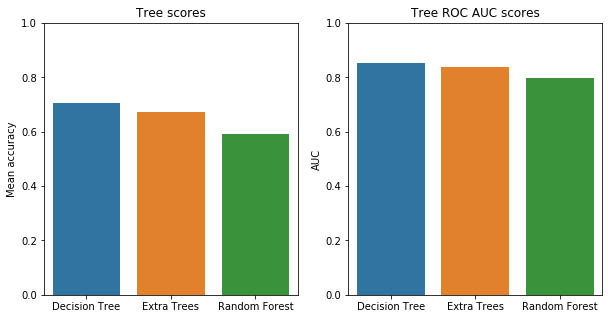

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(121)
ax = sns.barplot(x=['Decision Tree', 'Extra Trees', 'Random Forest'], y=[dec_tree_score, ex_tree_score, forest_score])
ax.set_title('Tree scores')
ax.set_ylabel('Mean accuracy')
ax.set_ylim(0,1)
plt.subplot(122)
ax = sns.barplot(x=['Decision Tree', 'Extra Trees', 'Random Forest'], y=[dec_tree_auc, ex_tree_auc, forest_auc])
ax.set_title('Tree ROC AUC scores')
ax.set_ylabel('AUC')
ax.set_ylim(0,1);

### Rank features via mean feature importance

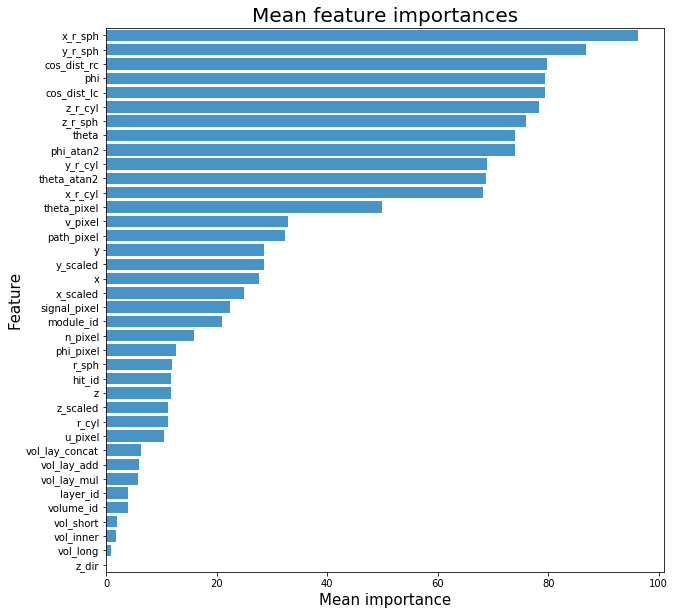

In [9]:
mm_scaler = MinMaxScaler(feature_range=(0, 100))

dec_tree_imps_scaled = mm_scaler.fit_transform(dec_tree.feature_importances_.reshape(-1, 1))
dec_tree_imps_scaled = dec_tree_imps_scaled.reshape(1,-1).ravel()
ex_tree_imps_scaled = mm_scaler.fit_transform(ex_tree.feature_importances_.reshape(-1, 1))
ex_tree_imps_scaled = ex_tree_imps_scaled.reshape(1,-1).ravel()
forest_imps_scaled = mm_scaler.fit_transform(forest.feature_importances_.reshape(-1, 1))
forest_imps_scaled = forest_imps_scaled.reshape(1,-1).ravel()

feature_importances = pd.DataFrame(np.stack((X.columns.values,  
                                             dec_tree_imps_scaled, 
                                             ex_tree_imps_scaled,
                                             forest_imps_scaled), axis=1),  
                                   columns=['feature','dec','ex','for'])

feature_importances['mean'] = feature_importances[['dec','ex','for']].mean(axis=1)
feature_importances = feature_importances.sort_values('mean', ascending=False)

plt.figure(figsize=(10,10))
ax = sns.barplot(x='mean', y='feature', data=feature_importances, color='#3498db');
ax.set_title('Mean feature importances', fontsize=20);
ax.set_xlabel('Mean importance', fontsize=15);
ax.set_ylabel('Feature',fontsize=15);

#### Pickle feature importances

In [10]:
feature_importances.to_pickle('/home/alepfu/Desktop/dataset/pickle/feature_importances.pkl')
print('done.')

done.
